In [85]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy.stats as stats 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from model_builder import ModelBuilder
from CustomRandomForest import CustomRandomForest
from model_utils import *
import shap
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import multipletests
from sklearn.metrics.pairwise import cosine_similarity
import joblib
from multiprocessing import Manager
plt.rcParams["font.family"] = "Times New Roman"
import warnings
warnings.filterwarnings("ignore")

# Helpful Functions

In [86]:
# These are the ones we want (for now)
# All Tasks
selected_tasks = ["Writing Story", "Divergent Association", "Wolf Goat Cabbage", "Room Assignment", "Sudoku", "Guess the Correlation", "Allocating Resources", "Moral Reasoning", "Word Construction", "Whac a Mole"]

# These 4 have similar score distributions for Teams with Chat (aka "Similarly Difficult")
# selected_tasks = ["Writing Story", "Divergent Association", "Wolf Goat Cabbage", "Room Assignment"]

# These four have distributions that didn't change acros All Players --> Teams --> Teams with Chat
# aka "Similar Levels of Synergy"
# selected_tasks = ["Allocating Resources", "Sudoku", "Moral Reasoning", "Writing Story"]

# These 2 are different for teams that did and didn't chat
# selected_tasks = ["Room Assignment", "Whac a Mole"]

In [87]:
min_num_chats = 0
data_path = "../output/"
tiny_multitask = 'conv/multi_task_TINY_output_conversation_level_stageId_cumulative.csv'
multitask_cumulative_by_stage = 'conv/multi_task_output_conversation_level_stageId_cumulative.csv'
multitask_cumulative_by_stage_and_task = 'conv/multi_task_output_conversation_level_stageId_cumulative_within_task.csv'

In [88]:
def drop_invariant_columns(df):
    """
    Certain features are invariant throughout the training data (e.g., the entire column is 0 throughout).

    These feature obviously won't be very useful predictors, so we drop them.
    
    This function works by identifying columns that only have 1 unique value throughout the entire column,
    and then dropping them.

    @df: the dataframe containing the features (this should be X).
    """
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    return(df.drop(cols_to_drop, axis=1))

def read_and_preprocess_data(path, min_num_chats, num_conversation_components = None):
	conv_data  = pd.read_csv(path)

	# Fill NA with mean
	conv_data.fillna(conv_data.mean(numeric_only=True), inplace=True)

	# Filter this down to teams that have at least min_num of chats
	# Can also comment this out to re-run results on *all* conversations!
	conv_data = conv_data[conv_data["sum_num_messages"] >= min_num_chats]

	# Filder this down to the selected tasks
	conv_data = conv_data[conv_data['task'].isin(selected_tasks)]


	# Save the important information

	# DV
	dvs = conv_data[["score","speed","efficiency","raw_duration_min","default_duration_min", "task"]]

	# Team Composition
	composition_colnames = ['birth_year', 'CRT', 'income_max', 'income_min', 'IRCS_GS', 'IRCS_GV', 'IRCS_IB', 'IRCS_IR',
				'IRCS_IV', 'IRCS_RS', 'political_fiscal', 'political_social', 'RME', 'country', 'education_level', 'gender', 'marital_status', 'political_party', 'race', 'playerCount']
	
	# Select columns that contain the specified keywords
	composition = conv_data[[col for col in conv_data.columns if any(keyword in col for keyword in composition_colnames)]]

	# Task
	task = conv_data[['task', 'complexity']].copy()

	task_map_path = '../utils/task_map.csv' # get task map
	task_map = pd.read_csv(task_map_path)

	task_name_mapping = {
		"Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
		"Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
		"Guess the Correlation": "Guessing the correlation",
		"Writing Story": "Writing story",
		"Room Assignment": "Room assignment task",
		"Allocating Resources": "Allocating resources to programs",
		"Divergent Association": "Divergent Association Task",
		"Word Construction": "Word construction from a subset of letters",
		"Whac a Mole": "Whac-A-Mole"
	}
	task.loc[:, 'task'] = task['task'].replace(task_name_mapping)
	task = pd.merge(left=task, right=task_map, on = "task", how='left')
	
	# Create dummy columns for 'complexity'
	complexity_dummies = pd.get_dummies(task['complexity'])
	task = pd.concat([task, complexity_dummies], axis=1)   
	task.drop(['complexity', 'task'], axis=1, inplace=True)

	# Conversation
	conversation = conv_data.drop(columns= list(dvs.columns) + list(composition.columns))._get_numeric_data()
	conversation = drop_invariant_columns(conversation) # drop invariant conv features

	# additional preprocess --- get PC's of conversation to reduce dimensionality issues
	if(num_conversation_components is not None):
		pca = PCA(n_components=num_conversation_components)
		pca_result = pca.fit_transform(conversation.transform(lambda x: (x - x.mean()) / x.std()))
		print("PCA explained variance:")
		print(np.sum(pca.explained_variance_ratio_))
		conversation = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

	# Standardize the DV
	dvs["score_grouped_std"] = dvs[["task", "score"]].groupby("task").transform(lambda x: (x - x.mean()) / x.std())
	dvs.drop("task", axis=1)

	return composition, task, conversation, dvs

In [89]:
team_composition_features, task_features, conv_features, targets = read_and_preprocess_data(data_path + multitask_cumulative_by_stage_and_task, min_num_chats=min_num_chats)

In [90]:
tasks = pd.read_csv(data_path + multitask_cumulative_by_stage)["task"].to_frame().rename(columns={"task": "task_name"})
tasks = tasks[tasks['task_name'].isin(selected_tasks)]

# Task Distribution Check

In [91]:
# this is everyone who played -- individuals and teams
full_multi_task_data = pd.read_csv('../data/raw_data/full_multi_task_data.csv').rename(columns={"task": "task_name"})

In [92]:
# This is all teams that played
team_multi_task_data = full_multi_task_data[full_multi_task_data["playerCount"]!=1]
# This is just the teams that chatted
tasks_and_scores = pd.concat([targets["score"],tasks], axis = 1)

In [93]:
def sort_by_mean_abs(df):
    return df.reindex(df["Mean"].abs().sort_values(ascending=False).index)

def split_dataframes_and_get_col(df, grouper, col = "score"):    
    grouped_df = df.groupby(grouper)
    return([group_df[col] for group_name, group_df in grouped_df])

def split_dataframes_and_get_tasknames(df, grouper):    
    grouped_df = df.groupby(grouper)
    return([pd.unique(group_df[grouper])[0] for group_name, group_df in grouped_df])

def get_score_distribution(task_score_df, task_name="task_name"):
    mean_var_datasets = pd.DataFrame(
        {
            "Task": split_dataframes_and_get_tasknames(task_score_df, grouper = task_name),
            "Variance": [np.var(x) for x in split_dataframes_and_get_col(task_score_df, grouper = task_name)],
            "Mean": [np.mean(x) for x in split_dataframes_and_get_col(task_score_df, grouper = task_name)]
        }
    )
    return sort_by_mean_abs(mean_var_datasets)

## Are some tasks simply harder than others?

Some tasks are like running a marathon --- it's a hard task for _everyone_, and requires substantial training in order to complete well. Other tasks are like a walk in the park --- anyone can do it well with little or no special effort. Here, we compare the distributions of scores across different tasks.

We see that some tasks are simply much harder than others: *Whac a Mole* is consistently the lowest-scoring task (mean in the 20's-30's), while *Writing Story* is consistently the highest scoring task (mean in the 90's).

In [94]:
# All Players
get_score_distribution(full_multi_task_data[["task_name", "score"]])

,Task,Variance,Mean
9,Writing Story,342.828209,89.500180
1,Divergent Association,417.334134,85.803048
4,Room Assignment,841.750616,75.825703
5,Sudoku,516.262311,73.628713
7,Wolf Goat Cabbage,1989.358949,67.909589
2,Guess the Correlation,735.769735,67.223242
3,Moral Reasoning,1122.703027,61.461039
0,Allocating Resources,1868.480993,56.105919
8,Word Construction,575.261064,35.348962
6,Whac a Mole,688.128504,23.592294


In [95]:
# All Teams
get_score_distribution(team_multi_task_data[["task_name", "score"]])

,Task,Variance,Mean
9,Writing Story,220.659607,92.151163
1,Divergent Association,130.744823,91.207289
7,Wolf Goat Cabbage,1159.523329,83.517413
4,Room Assignment,539.270895,81.404538
5,Sudoku,524.440350,76.977679
2,Guess the Correlation,611.407925,73.956284
3,Moral Reasoning,1068.850740,61.925287
0,Allocating Resources,1688.449437,61.081871
8,Word Construction,379.016663,49.696589
6,Whac a Mole,610.739214,21.134989


In [96]:
# Teams with Chat
get_score_distribution(tasks_and_scores)

,Task,Variance,Mean
9,Writing Story,223.477708,92.548501
1,Divergent Association,212.751207,90.495483
7,Wolf Goat Cabbage,764.783126,89.232558
4,Room Assignment,263.704421,87.202917
5,Sudoku,525.477359,78.711864
2,Guess the Correlation,611.597692,74.100000
0,Allocating Resources,1583.613258,64.913793
3,Moral Reasoning,1013.557692,62.500000
8,Word Construction,260.832699,48.679104
6,Whac a Mole,465.533950,36.986985


## Plot of Tasks by Variance and Mean

In [97]:
# Use numpy.where to get the corresponding word for each row
task_complexities = np.where(task_features['Low'] == 1, 'Low',
                    np.where(task_features['Medium'] == 1, 'Medium',
                             np.where(task_features['High'] == 1, 'High', 'Unknown')))

# Create a Series from the result
task_complexities = pd.Series(task_complexities, name='Task_Complexity')

In [98]:
# Individual Data
individual_multi_task_data = full_multi_task_data[full_multi_task_data["playerCount"]==1]

Define sets of data for individuals, teams

In [99]:
individual_multi_task_data["task_full"] = individual_multi_task_data["task_name"] + " (" + individual_multi_task_data["complexity"] + ")"
ind_multi_task_complexity = get_score_distribution(individual_multi_task_data, "task_full")
ind_multi_task_avg = get_score_distribution(individual_multi_task_data, "task_name")

In [100]:
team_multi_task_data["task_full"] = team_multi_task_data["task_name"] + " (" + team_multi_task_data["complexity"] + ")"

In [101]:
team_multi_task_complexity = get_score_distribution(team_multi_task_data, "task_full")
team_multi_task_avg = get_score_distribution(team_multi_task_data, "task_name")

In [102]:
def min_max_normalize(lst, source_list=None):
    if source_list is None:
        source_list = lst # By default, use the min and max from the target list. Otherwise, use the source_list to determine min and max.
    return [(x-np.min(source_list))/(np.max(source_list)-np.min(source_list)) for x in lst]

In [103]:
def task_to_marker(task, task_list):
    index = np.where(task_list == task)[0][0]
    markers = ['o', 's', '^', 'D', 'v', 'd', 'h', '+', 'p', '*']
    return markers[index]

def plot_task_mean_variance(df_means, df_with_complexity, plot_zero = False):

    """
    Plots the mean task performance on the x-axis, and the variance in task performance on the y-axis.

    @param df_means: a dataframe containing the performance per task (aggregated across all task instances.)
    We expect the following columns:
    - "Task" to contain task names;
    - "Mean" to contain the mean performance;
    - "Variance" to contain the variance in performance.

    @param df_with_complexity: a datafram containing the performance per task intance (complexity).
    We expect the following columns:
    - "task_name" to contain the task names;
    - "Task Complexity" to contain the level of task compexity, in {Low, Medium, High}
    - "Mean" to contain the mean performance;
    - "Variance" to contain the variance in performance.

    @param plot_zer (defaults to False) controls whether dotted lines should represent x=0/y=0.
    - By default, plots the medians.
    """

    # Plot first dataframe, containing the aggregated performance.
    plt.figure(figsize=(15, 15))

    # Set the list of tasks
    task_list = df_means["Task"].unique()

    for task in task_list:
        task_data = df_means[df_means["Task"] == task]
        plt.scatter(
            task_data["Mean"],
            task_data["Variance"],
            label=f"{task} Complexity",
            alpha=0.7,  # Adjust transparency if needed
            color = "gray",
            marker=task_to_marker(task, task_list),
            s=100
        )

    # Plot for each "Task_Complexity" category in the second dataframe
    complexity_colors = {'Low': 'forestgreen', 'Medium': 'darkorange', 'High': 'firebrick'}
    legend_handles = []  # List to store legend handles

    for label in ["Low", "Medium", "High"]:
        label_data = df_with_complexity[df_with_complexity["Task_Complexity"] == label]
        for task in task_list:
            task_data = label_data[label_data["task_name"] == task]  # Access data for the task from the first dataframe
            marker = task_to_marker(task, task_list)
            plt.scatter(
                task_data["Mean"],
                task_data["Variance"],
                alpha=0.5,
                marker= marker,
                s=100, 
                c=complexity_colors[label]
            )

        # Create legend handle with the correct marker and color
        legend_handles.append(plt.Line2D([0], [0], marker=marker, color=complexity_colors[label], label=f"{label} Complexity"))

    if plot_zero:
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.axvline(x=0, color='gray', linestyle='--')
    else:
        plt.axhline(y=np.median(list(df_means["Variance"]) + list(df_with_complexity["Variance"])), color='gray', linestyle='--')
        plt.axvline(x=np.median(list(df_means["Mean"]) + list(df_with_complexity["Mean"])), color='gray', linestyle='--')

    plt.legend(handles=legend_handles)

    # Annotate each point separately with larger text and centered above the dot
    for i, task in enumerate(df_means["Task"]):
        mean = df_means["Mean"].iloc[i]
        var = df_means["Variance"].iloc[i]
        plt.annotate(
            task,
            (mean, var),
            textcoords="offset points",
            xytext=(0, 25),
            ha='center',  # horizontally center text
            va='center',  # vertically center text
            fontsize=14   # set the font size
        )

    plt.xlabel("Mean Score", fontsize= 14)
    plt.ylabel("Variance in Score", fontsize= 14)
    plt.show()

In [104]:
# Min-Max Normalize both Team and Individual Data

# Team
team_multi_task_complexity["Mean"] = min_max_normalize(list(team_multi_task_complexity["Mean"]), source_list = list(list(team_multi_task_complexity["Mean"])) + list(team_multi_task_avg["Mean"]))
team_multi_task_complexity["Variance"] = min_max_normalize(list(team_multi_task_complexity["Variance"]), source_list = list(list(team_multi_task_complexity["Variance"])) + list(team_multi_task_avg["Variance"]))
team_multi_task_avg["Mean"] = min_max_normalize(list(team_multi_task_avg["Mean"]), source_list = list(list(team_multi_task_complexity["Mean"])) + list(team_multi_task_avg["Mean"]))
team_multi_task_avg["Variance"] = min_max_normalize(list(team_multi_task_avg["Variance"]), source_list = list(list(team_multi_task_complexity["Variance"])) + list(team_multi_task_avg["Variance"]))

# Individual
ind_multi_task_complexity["Mean"] = min_max_normalize(list(ind_multi_task_complexity["Mean"]), source_list = list(list(ind_multi_task_complexity["Mean"])) + list(ind_multi_task_avg["Mean"]))
ind_multi_task_complexity["Variance"] = min_max_normalize(list(ind_multi_task_complexity["Variance"]), source_list = list(list(ind_multi_task_complexity["Variance"])) + list(ind_multi_task_avg["Variance"]))
ind_multi_task_avg["Mean"] = min_max_normalize(list(ind_multi_task_avg["Mean"]), source_list = list(list(ind_multi_task_complexity["Mean"])) + list(ind_multi_task_avg["Mean"]))
ind_multi_task_avg["Variance"] = min_max_normalize(list(ind_multi_task_avg["Variance"]), source_list = list(list(ind_multi_task_complexity["Variance"])) + list(ind_multi_task_avg["Variance"]))

In [105]:
# Task Aggregate: Individual minus Team
task_varmean_df = ind_multi_task_avg
task_varmean_df[["Mean", "Variance"]] = ind_multi_task_avg[["Mean", "Variance"]]-team_multi_task_avg[["Mean", "Variance"]]

In [106]:
# Task Instance Data: Individual minus Team
score_distr_by_complexity = ind_multi_task_complexity
score_distr_by_complexity[["Mean", "Variance"]] = ind_multi_task_complexity[["Mean", "Variance"]]-team_multi_task_complexity[["Mean", "Variance"]]

# Requires additional preprocessing to meet requirements
pattern = r'\((.*?)\)'
score_distr_by_complexity['Task_Complexity'] = score_distr_by_complexity['Task'].str.extract(pattern)
score_distr_by_complexity['task_name'] = score_distr_by_complexity['Task'].str.replace(pattern, '').str.strip()

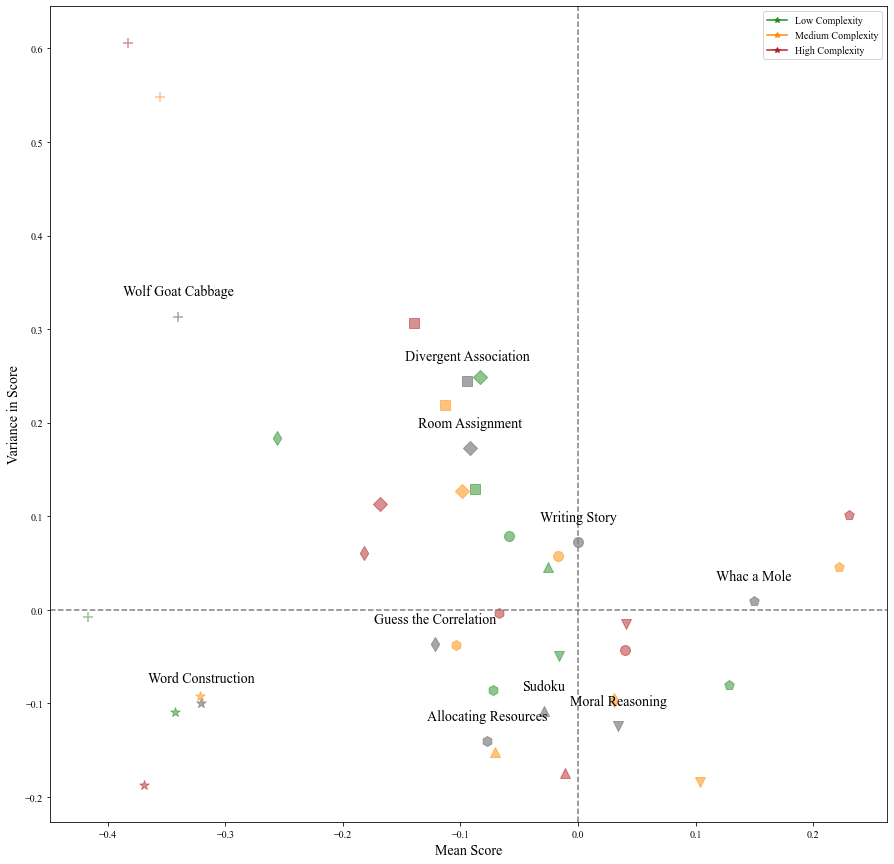

In [107]:
plot_task_mean_variance(task_varmean_df, score_distr_by_complexity, plot_zero=True)

### Plot of mean/variance in performance on team tasks (with chat), by complexity

In [108]:
# DF for average task performance (for teams with chat)
task_varmean_df_teams_with_chat = get_score_distribution(tasks_and_scores)

# DF for task performance per instance (for teams with chat)
task_complexities_and_scores = pd.concat([targets["score"],tasks,task_complexities], axis = 1)
task_complexities_and_scores["task_full"] = task_complexities_and_scores["task_name"] + " (" + task_complexities_and_scores["Task_Complexity"] + ")"
score_distr_by_complexity = get_score_distribution(task_complexities_and_scores, "task_full")
score_distr_by_complexity = score_distr_by_complexity.merge(task_complexities_and_scores, how="inner", left_on="Task", right_on="task_full")[["Task", "Task_Complexity", "Mean", "Variance", "task_name"]].drop_duplicates()

In [109]:
# Min-Max Normalize everything
score_distr_by_complexity["Mean"] = min_max_normalize(list(score_distr_by_complexity["Mean"]), source_list = list(list(task_varmean_df_teams_with_chat["Mean"])) + list(score_distr_by_complexity["Mean"]))
score_distr_by_complexity["Variance"] = min_max_normalize(list(score_distr_by_complexity["Variance"]), source_list = list(list(task_varmean_df_teams_with_chat["Variance"])) + list(score_distr_by_complexity["Variance"]))
task_varmean_df_teams_with_chat["Mean"] = min_max_normalize(list(task_varmean_df_teams_with_chat["Mean"]), source_list = list(list(task_varmean_df_teams_with_chat["Mean"])) + list(score_distr_by_complexity["Mean"]))
task_varmean_df_teams_with_chat["Variance"] = min_max_normalize(list(task_varmean_df_teams_with_chat["Variance"]), source_list = list(list(task_varmean_df_teams_with_chat["Variance"])) + list(score_distr_by_complexity["Variance"]))

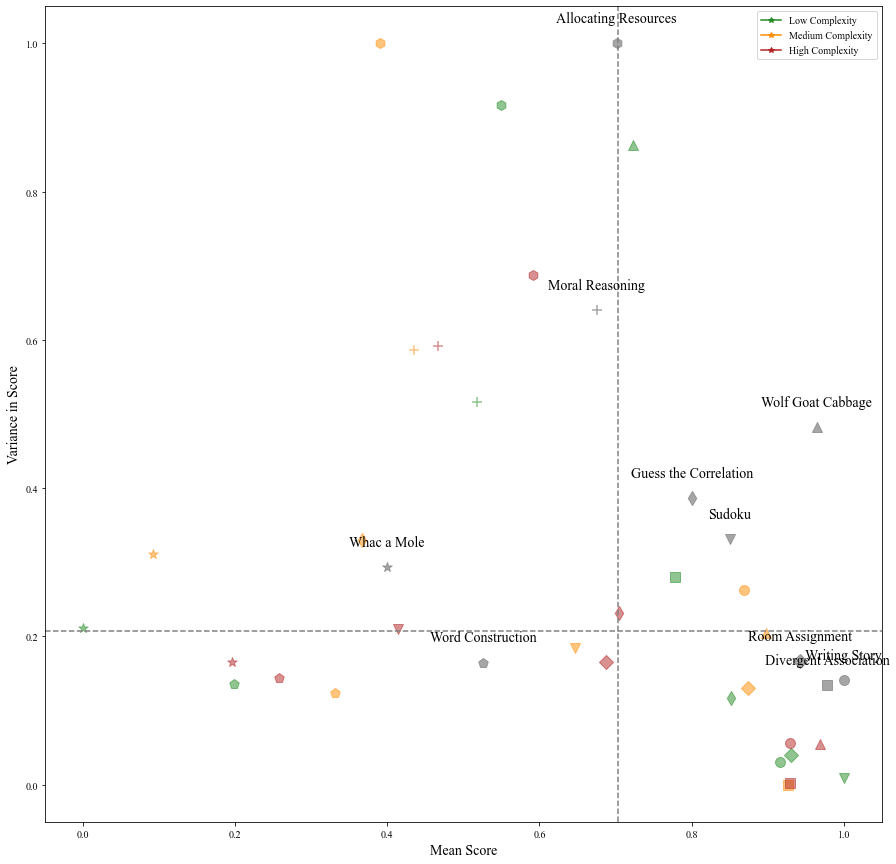

In [110]:
plot_task_mean_variance(task_varmean_df_teams_with_chat, score_distr_by_complexity)

### ANOVA for whether means are significantly different
Conduct a one-way ANOVA test to determine whether the mean scores are significantly different. This is a simple test for whether some tasks are simply harder than others.

In [13]:
stats.f_oneway(*split_dataframes_and_get_col(full_multi_task_data[["task_name", "score"]], grouper = "task_name"))

F_onewayResult(statistic=230.48940969513902, pvalue=0.0)

In [14]:
stats.f_oneway(*split_dataframes_and_get_col(team_multi_task_data[["task_name", "score"]], grouper = "task_name"))

F_onewayResult(statistic=258.1775615617606, pvalue=0.0)

In [15]:
stats.f_oneway(*split_dataframes_and_get_col(tasks_and_scores, grouper = "task_name"))

F_onewayResult(statistic=35.91294853053999, pvalue=1.5888463520913297e-55)

## Are the distributions the same across different playing groups?

On the other hand, there are two additional explanations:
1. Teams do better (worse) than individuals on certain tasks --- aka, *synergy*;
2. Some teams do better than others on certain tasks --- aka, *team specialization*.

In [16]:
def get_anova_stat_pvalue(scores_list):
    return stats.f_oneway(*scores_list)

def compare_group_distributions_anova(scores_df_list):
    tasks = scores_df_list[0]['task_name'].unique()
    alpha = 0.05
    p_values = []

    for task in tasks:

        scores_list = []
        for df in scores_df_list:
            scores_list.append(df[df['task_name'] == task]['score'])
        
        stat, p_value = get_anova_stat_pvalue(scores_list)

        # Collect p-values
        p_values.append(p_value)

    # Perform Benjamini-Hochberg correction
    _, corrected_p_values, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

    output_df = pd.DataFrame(
        {
            "Task": tasks,
            "ANOVA p-value": p_values
        }
    )

    output_df["Reject Null"] = np.where(output_df["ANOVA p-value"] < alpha, True, False)

    return output_df

In [17]:
df_general = full_multi_task_data[["task_name", "score"]]
df_teams = team_multi_task_data[["task_name", "score"]]
df_teams_with_chat = tasks_and_scores

In [18]:
compare_group_distributions_anova([df_general,df_teams,df_teams_with_chat])

,Task,ANOVA p-value,Reject Null
0,Room Assignment,5.986609e-05,True
1,Wolf Goat Cabbage,1.033918e-08,True
2,Guess the Correlation,4.536291e-03,True
3,Whac a Mole,9.599232e-03,True
4,Word Construction,1.378141e-12,True
5,Allocating Resources,1.225836e-01,False
6,Sudoku,8.113606e-02,False
7,Moral Reasoning,9.544035e-01,False
8,Writing Story,1.189885e-01,False
9,Divergent Association,4.191476e-03,True


Individuals and Teams scored significantly differently on *Room Assignment*, *Wolf Goat Cabbage*, *Guess the Correlation*, *Word Contruction*, and *Divergent Association*.

In all these cases, the average score in the task is higher for teams than for individuals, suggesting that teams benefitted from synergy.

In [19]:
compare_group_distributions_anova([df_general,df_teams])

,Task,ANOVA p-value,Reject Null
0,Room Assignment,1.948571e-02,True
1,Wolf Goat Cabbage,1.935680e-05,True
2,Guess the Correlation,5.832399e-03,True
3,Whac a Mole,6.981928e-02,False
4,Word Construction,2.783118e-11,True
5,Allocating Resources,2.176922e-01,False
6,Sudoku,1.280000e-01,False
7,Moral Reasoning,8.831357e-01,False
8,Writing Story,1.085361e-01,False
9,Divergent Association,3.071490e-03,True


Teams that did and didn't chat scored significiantly differently on *Room Assignment* and *Whac-A-Mole*.

Again, in these cases, the average score in the task is higher when teams chatted than when they didn't.

In [20]:
compare_group_distributions_anova([df_teams,df_teams_with_chat])

,Task,ANOVA p-value,Reject Null
0,Room Assignment,0.015804,True
1,Wolf Goat Cabbage,0.112125,False
2,Guess the Correlation,0.959751,False
3,Sudoku,0.530509,False
4,Moral Reasoning,0.878630,False
5,Whac a Mole,0.005932,True
6,Word Construction,0.708225,False
7,Allocating Resources,0.434597,False
8,Writing Story,0.820790,False
9,Divergent Association,0.677746,False


# Down-Selection of Conversation Features (Based on Domain Knowledge)

In [21]:
# # Quantity
# quantity = "num_chars"
# total_messages = "sum_num_messages"

# # Pace
# pace = "time_diff"

# # Content and Engagement
# lexicons_and_content = ["money", "stopword", "TTR"]
# politeness_strategies = ["please","please_start","hashedge","indirect_btw","hedges","factuality","deference","gratitude","apologizing","1st_person_pl","1st_person","1st_person_start","2nd_person","2nd_person_start","indirect_greeting","direct_question", "direct_start","haspositive","hasnegative","subjunctive","indicative"]

# # Equality
# equality = "gini_coefficient_sum_num_chars"

# # Emotion
# emotion = "positive_bert"

# # Variance
# variance = "mimicry_bert"

# # A really small set of features!
# # handpicked_colnames = [col for col in conv_features.columns if any(name in col for name in ["num_chars", "positive_bert"])]
# handpicked_colnames = [col for col in conv_features.columns if any(name in col for name in politeness_strategies + lexicons_and_content + [quantity, pace, emotion, variance])]

# def apply_rules(colname):
#     if("user" in colname): return False
#     if("average" not in colname and "stdev" not in colname): return False
#     else:
#         return True

# handpicked_colnames = [col for col in handpicked_colnames if apply_rules(col)]
# handpicked_colnames = handpicked_colnames + [equality, total_messages]

# # Apply this to conv_features
# conv_features = conv_features[handpicked_colnames]

In [22]:
def split_dataframes(df, grouper):    
    grouped_df = df.groupby(grouper)
    return([group_df for group_name, group_df in grouped_df])

In [23]:
# conv_plus_tasklabels = pd.concat([conv_features,tasks], axis = 1)
# labels = list(tasks["task_name"].unique())
# pca_results = plot_2d_dataframes(*split_dataframes(conv_plus_tasklabels, grouper = "task_name"), labels=labels, title = "PCA Scatter Plot of Conversations (By Task)")

# Running Models

In [24]:
# Note --- this uses k-fold cross-validation with k = 5 (the default)
# We are testing 10,000 different alphas, so I feel like this is an OK heuristic
def get_optimal_alpha(X_train, y_train, y_target, feature_columns_list, lasso):

    if(lasso == True):
        model = LassoCV(n_alphas = 10000)
        model.fit(X_train[feature_columns_list], y_train[y_target])
    else:
        model = RidgeCV(n_alphas = 10000)
        model.fit(X_train[feature_columns_list], y_train[y_target])
        
    return model.alpha_ # optimal alpha

def calculate_q2_parallelized(X_train, y_train, model, y_target, feature_columns_list, linear=True):
    # Use Manager to create shared lists
    manager = Manager()
    squared_model_prediction_errors = manager.list()
    squared_average_prediction_errors = manager.list()
    coefficients_list = manager.list()

    # Define a function for parallel execution
    def fit_and_predict(i):
        evaluation_X = X_train.iloc[[i]]
        evaluation_y = y_train.iloc[[i]][y_target]

        X_train_fold = X_train.drop(X_train.index[i])
        y_train_fold = y_train.drop(y_train.index[i])[y_target]

        # Fit the model
        model.fit(X_train_fold[feature_columns_list], y_train_fold)

        # Save the Prediction Error
        prediction = model.predict(evaluation_X[feature_columns_list])[0]
        squared_model_prediction_errors.append((evaluation_y - prediction) ** 2)

        # Save the Total Error for this fold
        squared_average_prediction_errors.append((evaluation_y - np.mean(y_train_fold)) ** 2)

        # Append the coefficients to the list
        if linear:
            coefficients_list.append(model.coef_)

    # Parallelize the loop
    joblib.Parallel(n_jobs=-1)(
        joblib.delayed(fit_and_predict)(i) for i in range(len(y_train))
    )

    # Convert shared lists to regular lists
    squared_model_prediction_errors = list(squared_model_prediction_errors)
    squared_average_prediction_errors = list(squared_average_prediction_errors)
    coefficients_list = list(coefficients_list)

    # Create a DataFrame with feature names as rows and iteration results as columns
    feature_coefficients = pd.DataFrame(coefficients_list, columns=feature_columns_list).T

    q_squared = 1 - (np.sum(squared_model_prediction_errors) / np.sum(squared_average_prediction_errors))
    return q_squared, feature_coefficients
def fit_regularized_linear_model(X_train, y_train, y_target, feature_columns_list, lasso=True, tune_alpha=False, prev_coefs = None, prev_alpha = None):

    if not tune_alpha:
        alpha = 1.0
    if (prev_alpha is not None):
        alpha = prev_alpha # use previous alpha
        print("Setting alpha to previous...")
        print(alpha)
    else:
        # Hyperparameter tune the alpha
        alpha = get_optimal_alpha(X_train, y_train, y_target, feature_columns_list, lasso=True)

    if lasso:
        model = Lasso(alpha=alpha)
    else:
        model = Ridge(alpha=alpha)

    if(prev_coefs is not None): # set weights to previous coefficients
        print("Setting coefficients ....")
        model.coef_ = prev_coefs
        print(model.coef_)

    q_squared, feature_coefficients = calculate_q2_parallelized(X_train, y_train, model, y_target, feature_columns_list)
    
    print("Q^2: " + str(q_squared))

    return model, q_squared, feature_coefficients

In [25]:
def display_feature_coefficients(feature_coef_df):
    # Initialize a list to store DataFrames for each feature
    dfs = []

    # Iterate through the rows of the input DataFrame
    for feature_name, coefficients in feature_coef_df.iterrows():
        # Calculate the confidence interval without NaN values
        non_nan_coefficients = coefficients[~np.isnan(coefficients)]
        if len(non_nan_coefficients) == 0:
            # Handle the case where there are no valid coefficients
            continue

        mean_coef = non_nan_coefficients.mean()

        # Check if all coefficients in the row are the same
        if len(coefficients.unique()) == 1:
            # If all coefficients are the same, set the lower and upper CI to the mean
            confidence_interval = (mean_coef, mean_coef)
        else:
            std_error = non_nan_coefficients.sem()
            confidence_interval = stats.t.interval(0.95, len(non_nan_coefficients) - 1, loc=mean_coef, scale=std_error)

        # Create a DataFrame for the summary data
        temp_df = pd.DataFrame({
            "Feature": [feature_name],
            "Mean": [mean_coef],
            "Lower_CI": [confidence_interval[0]],
            "Upper_CI": [confidence_interval[1]]
        })

        # Append the temporary DataFrame to the list
        dfs.append(temp_df)

    # Concatenate all the DataFrames in the list into the final summary DataFrame
    summary_df = pd.concat(dfs, ignore_index=True)

    return sort_by_mean_abs(summary_df)

In [26]:
team_composition_features.reset_index(drop=True, inplace=True)
task_features.reset_index(drop=True, inplace=True)
conv_features.reset_index(drop=True, inplace=True)

In [27]:
X_train = pd.concat([team_composition_features, task_features, conv_features], axis = 1)
y_train = targets

In [29]:
model, q_squared, feature_coefficients = fit_regularized_linear_model(X_train, y_train, y_target="score", feature_columns_list=task_features.columns, lasso=False, tune_alpha=True)

Q^2: 0.23323504392160666


In [30]:
display_feature_coefficients(feature_coefficients)

,Feature,Mean,Lower_CI,Upper_CI
22,Q5creativity_input_1,41.570133,41.564912,41.575354
3,Q6type_5_cc,-25.685501,-25.691578,-25.679425
6,Q9divisible_unitary,-25.012055,-25.015296,-25.008814
19,Q24eureka_question,-22.850365,-22.861137,-22.839593
8,Q11optimizing,20.191599,20.181947,20.201251
13,Q17within_sys_sol,-18.768273,-18.779743,-18.756802
9,Q13outcome_multip,18.133875,18.130229,18.137521
1,Q3type_1_planning,14.874848,14.865211,14.884485
7,Q10maximizing,-14.494884,-14.500190,-14.489579
12,Q16shared_knowledge,-14.078912,-14.080314,-14.077509


In [68]:
def run_random_forest(X, y, y_target, max_depth,feature_columns_list):
    model = RandomForestRegressor(n_estimators=100, max_depth=max_depth)
    q2, _ = calculate_q2_parallelized(X, y, model, y_target, feature_columns_list, linear = False)
    print(q2)

In [241]:
run_random_forest(X_train, y_train, y_target="score_grouped_std", max_depth=10, feature_columns_list=team_composition_features.columns)

-0.04852522958685013


# Custom Random Forest: Force in Task Features + Add other features on top

In [97]:
def run_custom_random_forest(X, y, y_target, max_depth, forced_features, n_additional_features, feature_columns_list):
    model = CustomRandomForest(n_estimators=100, max_depth=max_depth, forced_features=forced_features, n_additional_features=n_additional_features)
    q2, _ = calculate_q2_parallelized(X, y, model, y_target, feature_columns_list, linear = False)
    print(q2)

### Run the custom random forest with just task features

In [98]:
run_custom_random_forest(X_train, y_train, y_target="score", max_depth = 10, forced_features=task_features.columns, n_additional_features = 0, feature_columns_list=X_train.columns)

Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Done!
Done!
Done!
Done!
Done!
Growing trees...
Growing trees...
Growing trees...
Done!
Done!
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Done!
Making predictions...
Done!
Making predict

### Adding 10 additional features (from the non-Task)

Adding any 10 additional features

In [99]:
run_custom_random_forest(X_train, y_train, y_target="score", max_depth = 10, forced_features=task_features.columns, n_additional_features = 10, feature_columns_list=X_train.columns)

Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Done!
Done!
Done!
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Done!
Done!
Done!
Done!
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Done!
Making predictions...
Done!
Making predict

Forcing 10 features to be from the team communication columns

In [100]:
run_custom_random_forest(X_train, y_train, y_target="score", max_depth = 10, forced_features=task_features.columns, n_additional_features = 10, feature_columns_list=list(task_features.columns)+list(conv_features.columns))

Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Done!
Done!
Making predictions...
Making predictions...
Done!
Done!
Making predictions...
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Done!
Done!
Done!
Growing trees...
Done!
Growing trees...
Growing trees...
Done!
Growing trees...
Done!
Growing trees...
Done!
Growing trees...
Growing trees...
Growing trees...
Done!
Making predictions...
Done!
Done!
Making p

Forcing 10 features to be from the composition

In [109]:
run_custom_random_forest(X_train, y_train, y_target="score", max_depth = 10, forced_features=task_features.columns, n_additional_features = 10, feature_columns_list=list(task_features.columns)+list(team_composition_features.columns))

Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Done!
Done!
Making predictions...
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Done!
Making predictions...
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Growing trees...
Done!
Done!
Done!
Done!
Growing trees...
Done!
Growing trees...
Growing trees...
Done!
Growing trees...
Done!
Growing trees...
Growing trees...
Growing trees...
Done!
Making predictions...
Done!
Making predict

### Adding 20 Additional Features

In [101]:
run_custom_random_forest(X_train, y_train, y_target="score", max_depth = 10, forced_features=task_features.columns, n_additional_features = 20, feature_columns_list=X_train.columns)

Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Making predictions...
Done!
Done!
Done!
Done!
Done!
Growing trees...
Growing trees...
Done!
Growing trees...
Done!
Done!
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Growing trees...
Done!
Making predictions...
Done!
Making predict

### Using Tree Explainer to Explain Predictive Features

Model for 10 additional features

In [102]:
model = CustomRandomForest(n_estimators=100, max_depth=10, forced_features=task_features.columns, n_additional_features=10)
model.fit(X_train, y_train["score"])

Growing trees...
Done!


In [130]:
def get_shap_values(mdel, X):

    explainer = shap.TreeExplainer(mdel)
    shap_values = explainer.shap_values(X)


    shap_feature_correlation = []
    for feature_name in X.columns:
        feature_values = X[feature_name]
        feature_index = X.columns.get_loc(feature_name)  # Get the index of the feature
        shapley_values = shap_values[:, feature_index]
        # Create a DataFrame with the two columns and calculate the correlation
        df = pd.DataFrame({'feature_values': feature_values, 'shapley_values': shapley_values})
        correlation_coefficient = df.corr(method='pearson').iloc[0, 1]   
        shap_feature_correlation.append(correlation_coefficient)
    shap_mean_abs = np.mean(np.abs(shap_values), axis = 0)
    shap_df = pd.DataFrame({
        'feature': X.columns,
        'shap': shap_mean_abs,
        'correlation_btw_shap_and_feature_value': shap_feature_correlation
    })
    
    return shap_values, shap_df.reindex(shap_df["shap"].abs().sort_values(ascending=False).index)

In [104]:
shap_values, shap_df = get_shap_values(model, X_train)
shap_df.head(20)

,feature,shap,correlation_btw_shap_and_feature_value
22,income_max_nanstd,4.618364,0.075024
29,political_party_nanmean,2.976636,-0.606899
31,political_social_nanmean,2.789428,-0.110236
27,political_fiscal_nanmean,2.736515,-0.524786
28,political_fiscal_nanstd,2.691751,-0.575884
36,Q6type_5_cc,2.441355,-0.365900
35,Q4type_2_generate,2.403897,-0.730074
30,political_party_nanstd,2.191781,-0.532485
25,marital_status_nanmean,1.954159,-0.625079
32,political_social_nanstd,1.937297,0.053865


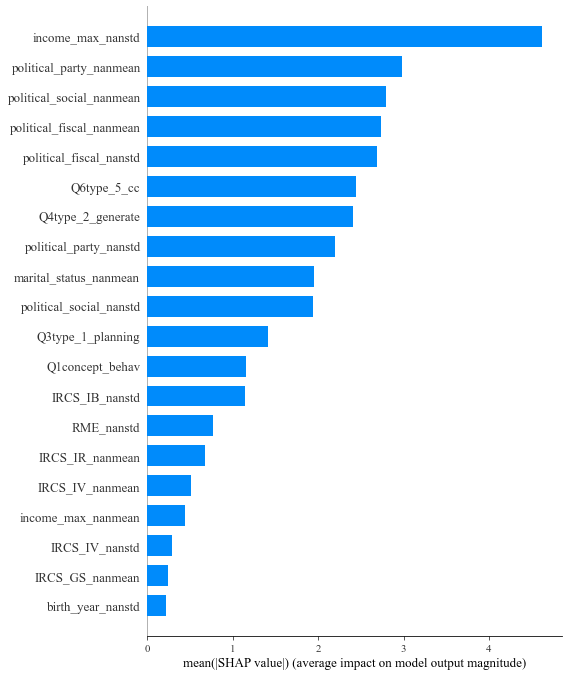

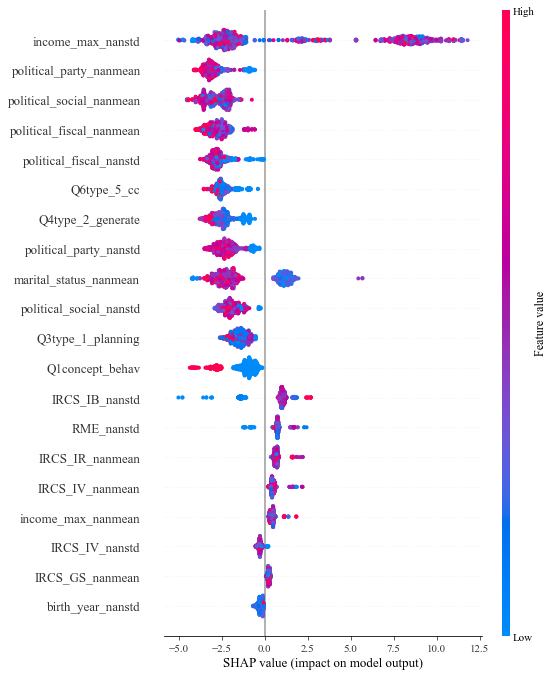

In [105]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type="bar")
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

Model for 10 conversational features

In [106]:
model2 = CustomRandomForest(n_estimators=100, max_depth=10, forced_features=task_features.columns, n_additional_features=10)
model2.fit(X_train[list(task_features.columns)+list(conv_features.columns)], y_train["score"])

Growing trees...
Done!


In [107]:
shap_values2, shap_df2 = get_shap_values(model2, X_train[list(task_features.columns)+list(conv_features.columns)])
shap_df2.head(20)

,feature,shap,correlation_btw_shap_and_feature_value
22,Q5creativity_input_1,7.984660,0.709543
8,Q11optimizing,3.425096,0.889933
31,stdev_positive_bert,3.317918,-0.449899
25,Low,2.976976,0.472357
33,max_positive_bert,2.646210,-0.273806
28,gini_coefficient_sum_num_chars,1.922840,-0.290713
30,average_positive_bert,1.804761,-0.067430
27,gini_coefficient_sum_num_words,1.744011,-0.372519
29,gini_coefficient_sum_num_messages,1.699678,-0.528761
34,average_negative_bert,1.503951,-0.248244


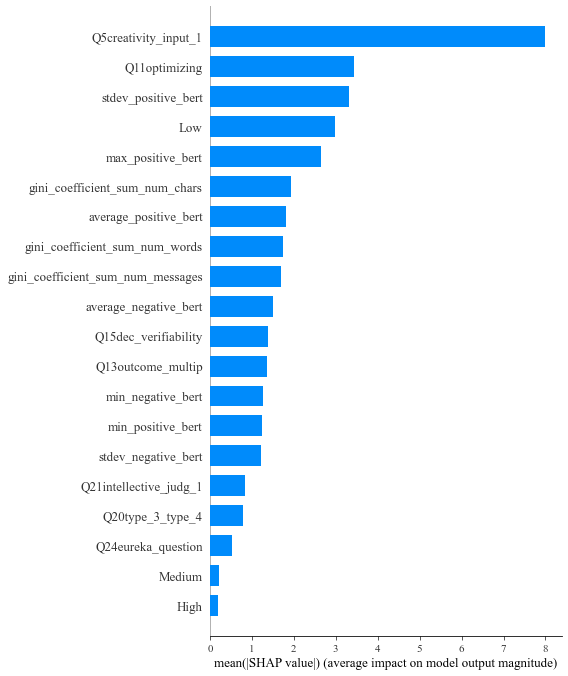

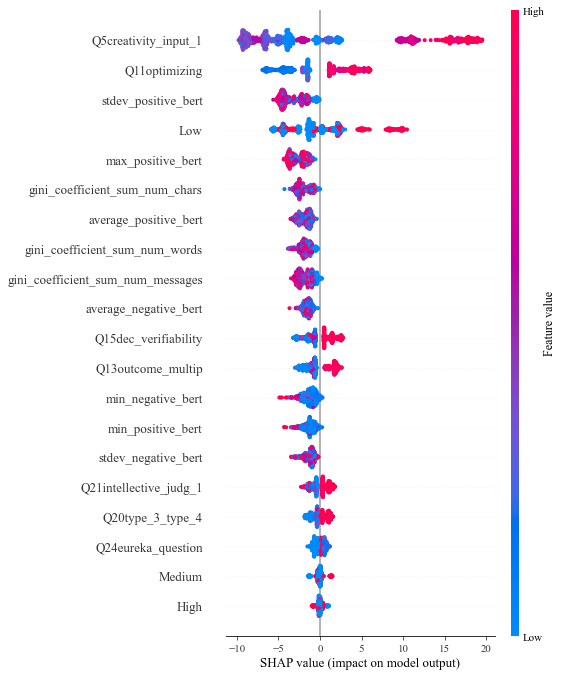

In [108]:
shap.summary_plot(shap_values2, X_train[list(task_features.columns)+list(conv_features.columns)], feature_names=X_train[list(task_features.columns)+list(conv_features.columns)].columns, plot_type="bar")
shap.summary_plot(shap_values2, X_train[list(task_features.columns)+list(conv_features.columns)], feature_names=X_train[list(task_features.columns)+list(conv_features.columns)].columns)

## Do this for a normal RF

In [181]:
model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train, y_train["score_grouped_std"])

RandomForestRegressor(max_depth=10)

In [182]:
shap_values, shap_df = get_shap_values(model, X_train)
shap_df.head(20)

,feature,shap,correlation_btw_shap_and_feature_value
67,average_negative_bert,0.048838,-0.797067
58,Low,0.029126,0.851332
23,income_min_nanmean,0.016863,0.632769
1064,max_user_avg_positive_words_lexical_per_100,0.015659,0.679410
1200,max_user_avg_haspositive,0.013689,0.696514
940,average_user_avg_positive_affect_lexical_per_100,0.011355,0.597754
733,average_user_sum_positivity_zscore_chats,0.010080,0.700479
1197,average_user_avg_haspositive,0.009791,0.668395
11,IRCS_IV_nanmean,0.009183,-0.438857
152,stdev_body_lexical_per_100,0.008519,-0.447831


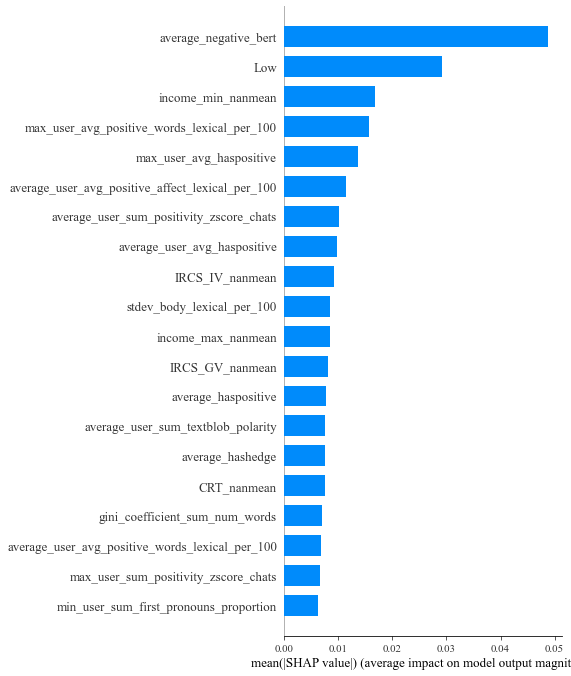

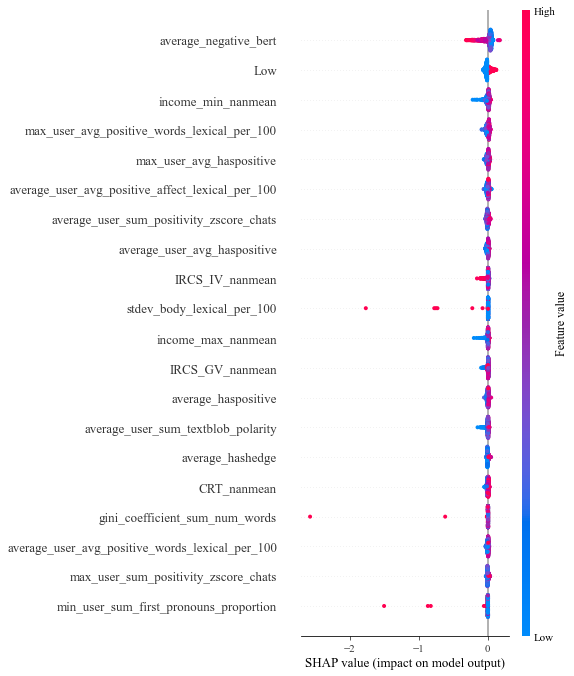

In [183]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type="bar")
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)